In [36]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
from GraphLaplacian.binary import GraphLaplacian, MBOBinary
from GraphLaplacian.multilabel import GLMultiClass, MBOMultiClass
from GraphLaplacian.helper import plot#, plot2d
import pdb
from IPython.display import clear_output
from sklearn.datasets import make_moons, make_circles, make_classification
import scipy
import pdb
from datetime import datetime

matplotlib.rcParams['figure.figsize'] = [7, 7]
sns.set()
sns.set_style("ticks")

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [37]:
import random
import math

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def create_score_sheet(method, y_true, y_pred):
    return {"Method":method, 
            "accuracy":accuracy_score(y_true, y_pred), 
            "f1_score": f1_score(y_true, y_pred), 
            "presicion": precision_score(y_true, y_pred), 
            "recall": recall_score(y_true, y_pred)}

def find_h(X, n_sample=5, n_neigh=5, use_mean=False):
    np.random.seed(1000)
    tree = scipy.spatial.cKDTree(X)
    sample = random.sample(X, k=n_sample)
    _func = lambda point: np.mean([x for x in tree.query(point, k = n_neigh+1)[0] if x > 0])
    if use_mean:
        h = np.mean([_func(x) for x in sample])
    else:
        h = np.max([_func(x) for x in sample])
    return h

# Xr = random.choices(X, k=10)

In [38]:
colors = ["#ffffff", "#ff6361", "#003f5c", "#63005c", "#006355", "#5c3f00"]
sns.set_palette(sns.color_palette(colors))

In [39]:
def plot2d(model, return_ax=False, title=""):
    colors = ["#ed705c", "#79b1ed", "#ffb3ff", "#82d4d1", "#f5dd9f"]
    sns.set_palette(sns.color_palette(colors))
    # X = list(X0) + list(X1)
    X0 = model._X0
    X1 = model._X1
    Y1 = model.Y[len(X0):]
    Y0 = model.Y[:len(X0)]
    Y = model.Y

    xx = [x[0] for x in X1]
    xy = [x[1] for x in X1]
    max_lim = max(max(xx), max(xy)) + 0.1
    min_lim = min(min(xx), min(xy)) + 0.1
    df = pd.DataFrame(X1, columns=["x1", "x2"])
    df.loc[:, "label"] = [str(Y1[i]) if i < len(Y1) else "unknown" for i, y in enumerate(X1)]
    df = df.sort_values(by=["label"], ascending=True)

    fig, ax = plt.subplots()
    # dplot = df[df["label"] == "unknown"]
    # ax.scatter(dplot["x1"], dplot["x2"], label="unknown", s=15)

    for label in df[df["label"] != "unknown"].label.unique():
        dplot = df[df["label"] == label]
        ax.scatter(dplot["x1"], dplot["x2"], label=label, s=11)

    df = pd.DataFrame(X0, columns=["x1", "x2"])
    df.loc[:, "label"] = ["Initial_" + str(Y0[i]) if i < len(Y0) else "unknown" for i, y in enumerate(X0)]
    df = df.sort_values(by=["label"], ascending=True)
    colors = ["#691b05", "#071e7a", "#690664", "#006355", "#5c3f00"]
    for i, label in enumerate(df[df["label"] != "unknown"].label.unique()):
        dplot = df[df["label"] == label]
        ax.scatter(dplot["x1"], dplot["x2"], label=label, s=30, marker="x", color=colors[i])
    # ax.scatter(np.array(X0).T[0], np.array(X0).T[1], label="Initial Data", s=15, marker="x", color="red")

    ax.set_xlim(min_lim, max_lim)
    ax.set_ylim(min_lim, max_lim)
    ax.set_title(title)

    ax.legend()
    if return_ax:
        return ax
    plt.show()

### Data

In [12]:
np.random.seed(1000)
cov1 = np.array([[6,0],[0,2]])
blue = np.random.multivariate_normal(mean=[0,2], cov=cov1, size=500)
np.random.seed(999)
cov2 = np.array([[6,0],[0,2]])
red = np.random.multivariate_normal(mean=[0,-3], cov=cov2, size=500)
Y = list(np.ones(len(blue))) + list(np.ones(len(red))*0)
X = list(blue) + list(red)

In [13]:
# Get h
h = find_h(X, len(X), 1, use_mean=False)/3.7
h

0.532782945993442

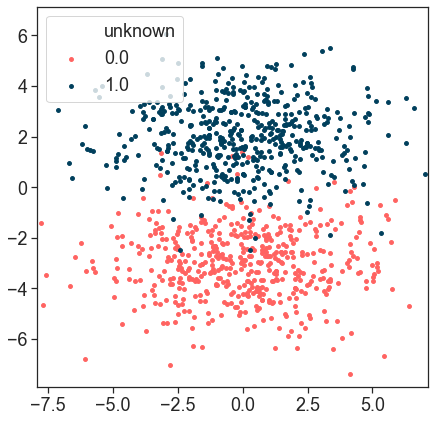

In [14]:
plot(X, Y, [])

In [15]:
# N = 50
# X0 = list(blue[:N]) + list(red[:N])
# Y0 = list(np.ones(len(blue)))[:N] + list(np.ones(len(red))*0)[:N]
# X1 = list(blue[N:]) + list(red[N:])
# Y1 = list(np.ones(len(blue)))[N:] + list(np.ones(len(red))*0)[N:]
# h = max(find_h(X, Xr, 10))

In [ ]:
N = 20
N_imb = 5
X0 = list(blue[:N]) + list(red[:N_imb*N])
Y0 = list(np.ones(len(blue)))[:N] + list(np.ones(len(red))*0)[:N_imb*N]
X1 = list(blue[N:]) + list(red[N_imb*N:])
Y1 = list(np.ones(len(blue)))[N:] + list(np.ones(len(red))*0)[N_imb*N:]
h = find_h(X, len(X), 1, use_mean=False)/3.7
ax = plot(X0, Y0, X1, return_ax=True)
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)

In [ ]:
h

In [ ]:
GL = GraphLaplacian(X0, Y0, X1, sigma=h)
GL.solve()
plot2d(GL)

In [ ]:
MBO = MBOBinary(X0, Y0, X1, sigma=h, dT=0.0001, Nd=1)
MBO.solve()
plot2d(MBO)

In [ ]:
GL = GraphLaplacian(X0, Y0, X1, cov=1)
GL.solve()
plot2d(GL)

In [ ]:
# f1_score = create_score_sheet("MBO", Y, MBO.Y).get("f1_score")
# f1_score

In [ ]:
display(plot(X0 + X1, MBO.Y, []))

## Test Kasus Lain

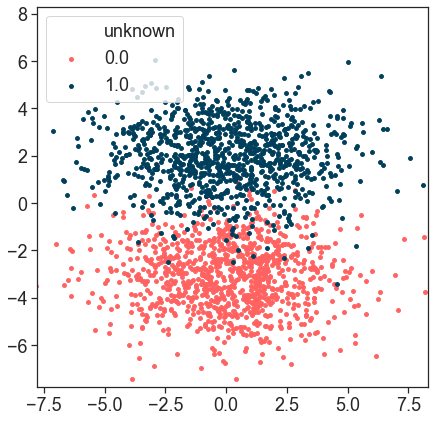

In [41]:
cov1 = np.array([[6,0],[0,2]])
blue = np.random.multivariate_normal(mean=[0,2], cov=cov1, size=1000)
cov2 = np.array([[6,0],[0,2]])
red = np.random.multivariate_normal(mean=[0,-3], cov=cov2, size=1000)
Y = list(np.ones(len(blue))) + list(np.ones(len(red))*0)
X = list(blue) + list(red)
h = find_h(X, len(X), 1, use_mean=False)/3.6
plot(X, Y, [])

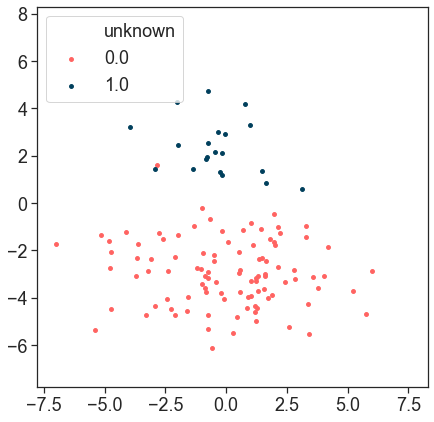

In [42]:
N = 20
gamma = 5
X0 = list(blue[:N]) + list(red[:gamma*N])
Y0 = list(np.ones(len(blue)))[:N] + list(np.ones(len(red))*0)[:gamma*N]
X1 = list(blue[N:]) + list(red[gamma*N:])
Y1 = list(np.ones(len(blue)))[N:] + list(np.ones(len(red))*0)[gamma*N:]
plot(X0, Y0, X1)

Graph Laplacian


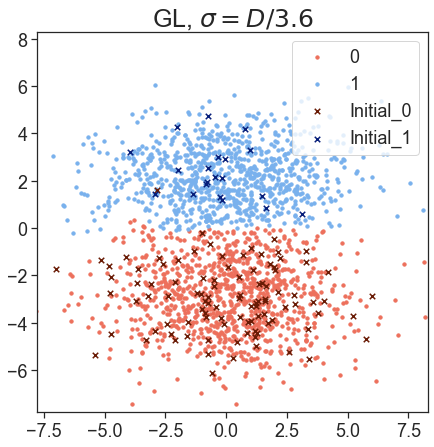

In [43]:
print("Graph Laplacian")
GL = GraphLaplacian(X0, Y0, X1, sigma=h)#, weight_matrix=weight_matrix)
GL.solve()
plot2d(GL, title=r"GL, $\sigma=D/3.6$")

Graph Laplacian


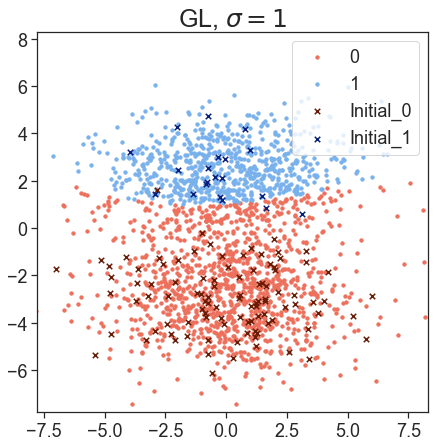

In [44]:
print("Graph Laplacian")
GL = GraphLaplacian(X0, Y0, X1, sigma=1)#, weight_matrix=weight_matrix)
GL.solve()
plot2d(GL, title=r"GL, $\sigma=1$")

Calculate weight matrix... DONE
Interation 0 error 0.5934343434343434
Interation 1 error 0.0


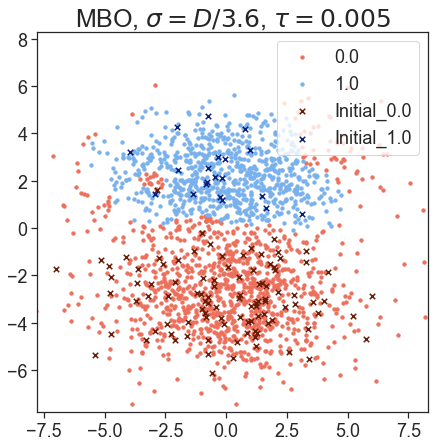

In [45]:
MBO = MBOBinary(X0, Y0, X1, sigma=h, dT=0.005, initial="0.5")
MBO.solve()
plot2d(MBO, title="MBO, $\sigma=D/3.6$, $\\tau=0.005$")

Calculate weight matrix... DONE
Interation 0 error 0.5781057810578106
Interation 1 error 0.0


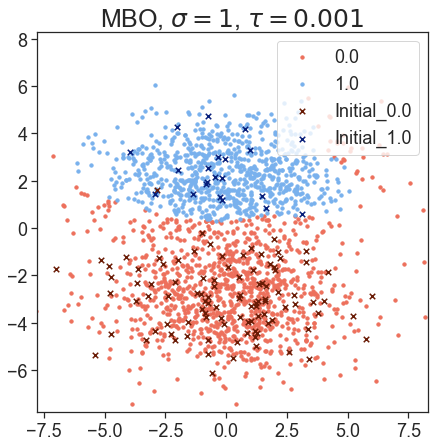

In [46]:
MBO = MBOBinary(X0, Y0, X1, sigma=1, dT=0.001, initial="0.5")
MBO.solve()
plot2d(MBO, title="MBO, $\sigma=1$, $\\tau=0.001$")

In [ ]:
f1_score(Y, MBO.Y)

## Test Kasus Lain 2

In [47]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

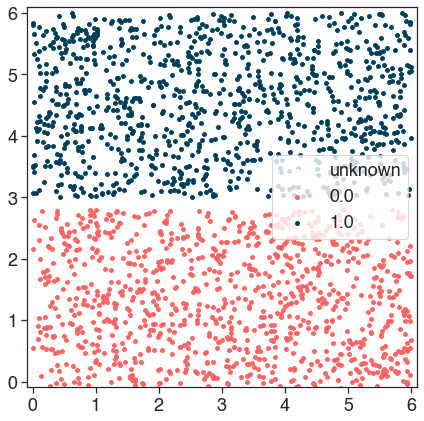

In [48]:
blue = list(zip(np.random.random(1000)*6, np.random.random(1000)*3 + 3))
red = list(zip(np.random.random(1000)*6, np.random.random(1000)*3 - 0.2))
Y = list(np.ones(len(blue))) + list(np.ones(len(red))*0)
X = list(blue) + list(red)
plot(X, Y, [])

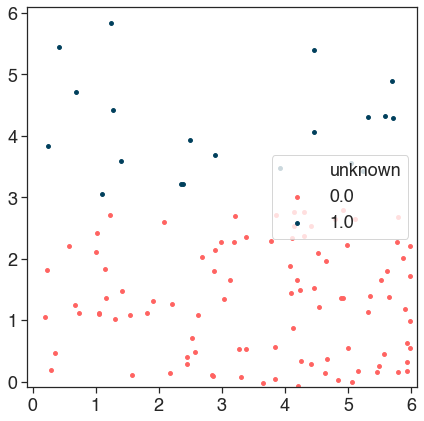

In [49]:
N = 20
gamma = 5
X0 = list(blue[:N]) + list(red[:gamma*N])
Y0 = list(np.ones(len(blue)))[:N] + list(np.ones(len(red))*0)[:gamma*N]
X1 = list(blue[N:]) + list(red[gamma*N:])
Y1 = list(np.ones(len(blue)))[N:] + list(np.ones(len(red))*0)[gamma*N:]
plot(X0, Y0, X1)

In [50]:
# Get h
# Xr = random.choices(X, k=10)
# h = max(find_h(X, Xr, 10))
h = find_h(X, len(X), 1, use_mean=False)/3.6
h

0.06523192365266835

Graph Laplacian


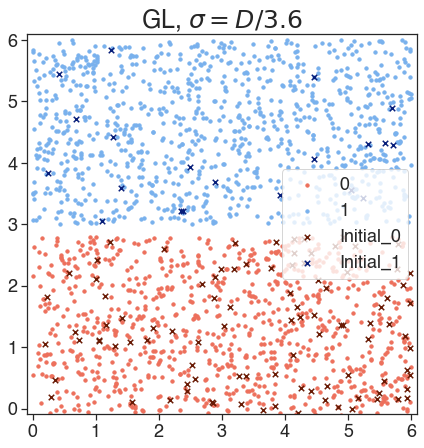

In [51]:
print("Graph Laplacian")
GL = GraphLaplacian(X0, Y0, X1, sigma=h)#, weight_matrix=weight_matrix)
GL.solve()
plot2d(GL, title=r"GL, $\sigma=D/3.6$")

Graph Laplacian


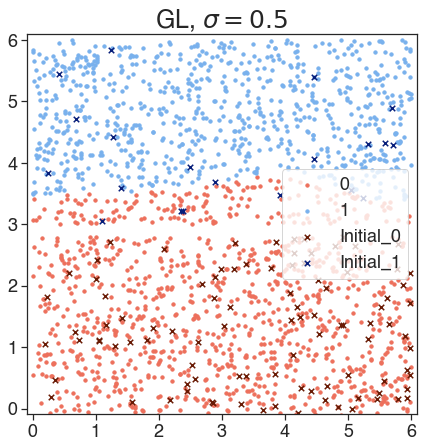

In [52]:
print("Graph Laplacian")
GL = GraphLaplacian(X0, Y0, X1, sigma=0.5)#, weight_matrix=weight_matrix)
GL.solve()
plot2d(GL, title="GL, $\sigma=0.5$")

Calculate weight matrix... DONE
Interation 0 error 2.034632034632035
Interation 1 error 0.0


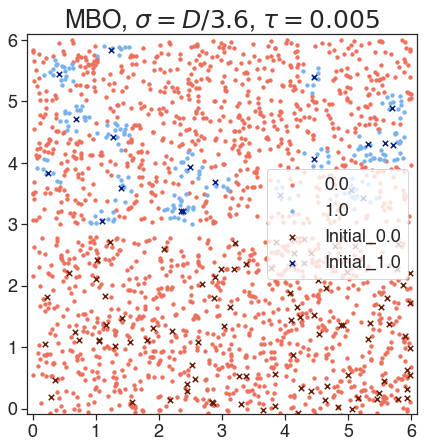

In [53]:
MBO = MBOBinary(X0, Y0, X1, sigma=h, dT=0.005, initial="0.5")
MBO.solve()
plot2d(MBO, title="MBO, $\sigma=D/3.6$, $\\tau=0.005$")

Calculate weight matrix... DONE
Interation 0 error 0.4978813559322034
Interation 1 error 0.0


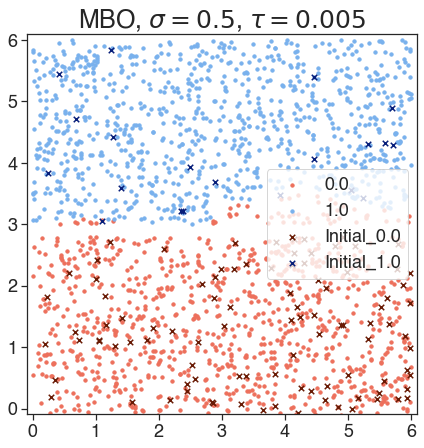

In [54]:
MBO = MBOBinary(X0, Y0, X1, sigma=0.5, dT=0.005, initial="0.5")
MBO.solve()
plot2d(MBO, title="MBO, $\sigma=0.5$, $\\tau=0.005$")

In [55]:
print(f1_score(Y, GL.Y), f1_score(Y, MBO.Y))

0.8081140350877192 0.8734567901234567


## Test Kasus Lain 3

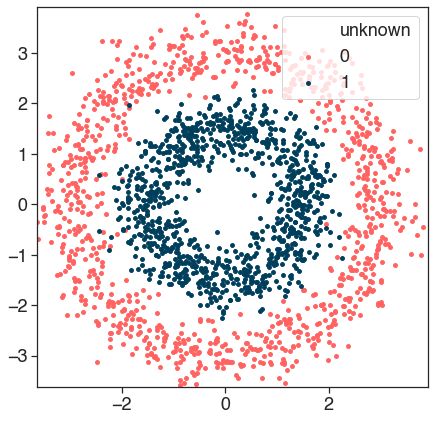

In [56]:
X, Y = make_circles(noise=0.11, factor=0.5, random_state=1, n_samples=2000)
X = X * 3

plot(X,Y,[])

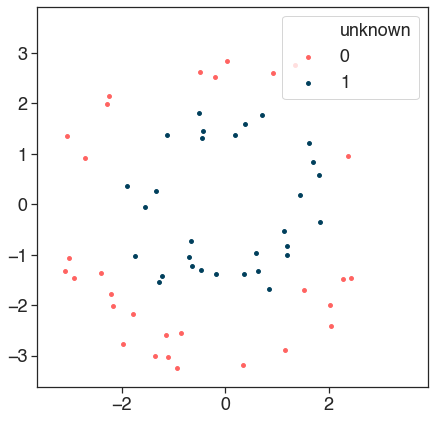

In [57]:
N = 30
gamma = 1
X0 = list([X[i] for i,y in enumerate(Y) if y==0][:N] + [X[i] for i,y in enumerate(Y) if y==1][:gamma*N])
Y0 = list([y for y in Y if y==0][:N] + [y for y in Y if y==1][:gamma*N])
X1 = list(X[(1+gamma)*N:])
# X = X0 + X1
plot(X0, Y0, X1)

In [58]:
# Get h
# Xr = random.choices(X, k=10)
# h = max(find_h(X, Xr, 10))
h = find_h(list(X), len(X), 1, use_mean=False)/3.6
h

0.13665272654930943

Graph Laplacian


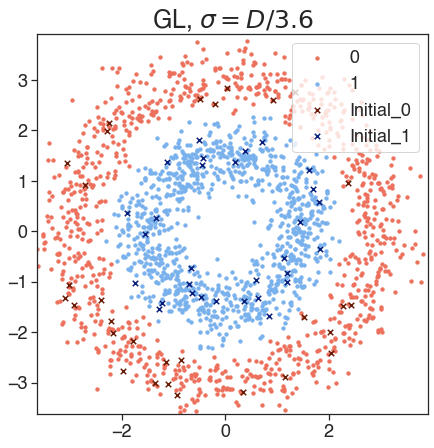

In [59]:
print("Graph Laplacian")
GL = GraphLaplacian(X0, Y0, X1, sigma=h)#, weight_matrix=weight_matrix)
GL.solve()
plot2d(GL, title=r"GL, $\sigma=D/3.6$")

Graph Laplacian


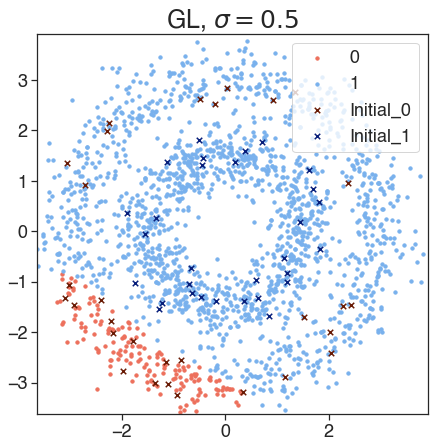

In [60]:
print("Graph Laplacian")
GL = GraphLaplacian(X0, Y0, X1, sigma=0.5)#, weight_matrix=weight_matrix)
GL.solve()
plot2d(GL, title="GL, $\sigma=0.5$")

Calculate weight matrix... DONE
Interation 0 error 0.5449438202247191
Interation 1 error 0.0


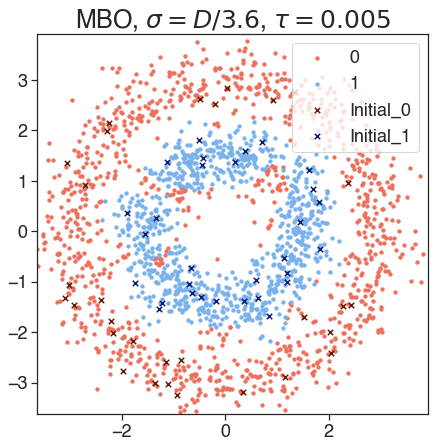

In [61]:
MBO = MBOBinary(X0, Y0, X1, sigma=h, dT=0.005, initial="0.5")
MBO.solve()
plot2d(MBO, title="MBO, $\sigma=D/3.6$, $\\tau=0.005$")

Calculate weight matrix... DONE
Interation 0 error 0.4532710280373832
Interation 1 error 0.0


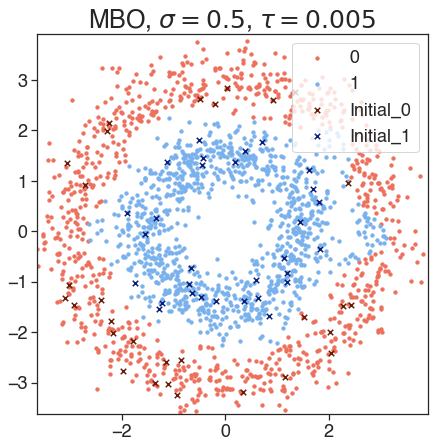

In [62]:
MBO = MBOBinary(X0, Y0, X1, sigma=0.5, dT=0.005, initial="0.5")
MBO.solve()
plot2d(MBO, title="MBO, $\sigma=0.5$, $\\tau=0.005$")

In [ ]:
f = lambda c, dh : c*np.exp(-dh**2/2) / (1 + c*np.exp(-dh**2/2))
cs = [2,3,4,5]
dh = np.linspace(0, 5, 1000)
for c in cs:
    ux = f(c, dh)
    plt.plot(dh, ux)
    
plt.legend(["C={}".format(c) for c in cs])
plt.xlabel(r"$\delta/\tilde{\sigma}$", size=20)
plt.ylabel(r"$u_z$", size=20)